In [1]:

import glob, sys, sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from colorama import Fore, Back, Style
from matplotlib.ticker import PercentFormatter
from matplotlib.pyplot import figure


In [2]:

# Noms de colonnes à utiliser
names = ['Code Domaine', 'Domaine', 'Code Pays', 'Pays', 'Code Élément', 'Élément', 'Code Produit',
         'Produit', 'Code Année', 'Année', 'Unité', 'Valeur', 'Symbole', 'Description du Symbole']

fns = glob.glob('*/*.csv')

conn = sqlite3.connect('bdd.sqlite')

for fn in fns:

    fns = fn.split('/')[-1][13:-4]

    if fns == 'Groupe_de_pays':
        df = pd.read_csv(fn)
    else:
        df = pd.read_csv(fn, names=names, header=0)

    print(f" - {fn:50s} ({df.shape[0]:6d}, {df.shape[1]:2d}) - {Fore.BLACK}{Back.GREEN}{fns}{Style.RESET_ALL}")
    df.to_sql(fns, con=conn, if_exists='replace')

# Récupération des données dans un sql

plt.rcParams["figure.figsize"] = (22,10)


 - data/FAOSTAT_2013_vegetal.csv                      (104871, 14) - vegetal
 - data/FAOSTAT_2013_animal.csv                       ( 37166, 14) - animal
 - data/FAOSTAT_2013_superficie.csv                   (   238, 14) - superficie
 - data/FAOSTAT_2023_Groupe_de_pays.csv               (  1941,  7) - Groupe_de_pays
 - data/FAOSTAT_2013_population.csv                   (   175, 14) - population
 - data/FAOSTAT_2013_sous_alimentation.csv            (   204, 14) - sous_alimentation
 - data/FAOSTAT_2013_cereal.csv                       ( 16057, 14) - cereal


In [5]:

def pareto(SQL, columnX, columnY, title = None, columnColor = None, dictColor = None):

    df = pd.read_sql(SQL, conn).sort_values(by=columnY, ascending=False)

    df['cumperc'] = df[columnY].cumsum() / df[columnY].sum() * 100
    df[columnY] = np.log(df[columnY])
    #print(df)

    acti_color = (columnColor and dictColor)

    if acti_color:

        change = lambda x: dictColor[x] if x in dictColor else dictColor['Other']
        colors = df[columnColor].apply(change)

    x, y = df[columnX], df[columnY]

    _, ax = plt.subplots()

    if acti_color:
        ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7, color=colors)
    else:
        ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

    color1 = 'steelblue'
    color2 = 'red'

    ax2 = ax.twinx()
    ax2.plot(df[columnX], df['cumperc'], color=color2, marker="D", ms=1)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis='y', colors=color1)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax2.tick_params(axis='y', colors=color2)

    if acti_color:
        list_legend = [mpatches.Patch(color=dictColor[key], label=key) for key in dictColor]
        plt.legend(handles=list_legend, loc='upper right')

    if title : ax.set_title(title, loc='center')
    ax.margins(0.005)

    plt.show()


In [6]:

dictColor = {

    "Amériques" : "y",
    "Afrique"   : "r",
    "Océanie"   : "m",
    "Europe"    : "g",
    "Asie"      : "b",
    "Other"     : "gray"

}

list_groupes = f"""('{"', '".join(list(dictColor))}')"""


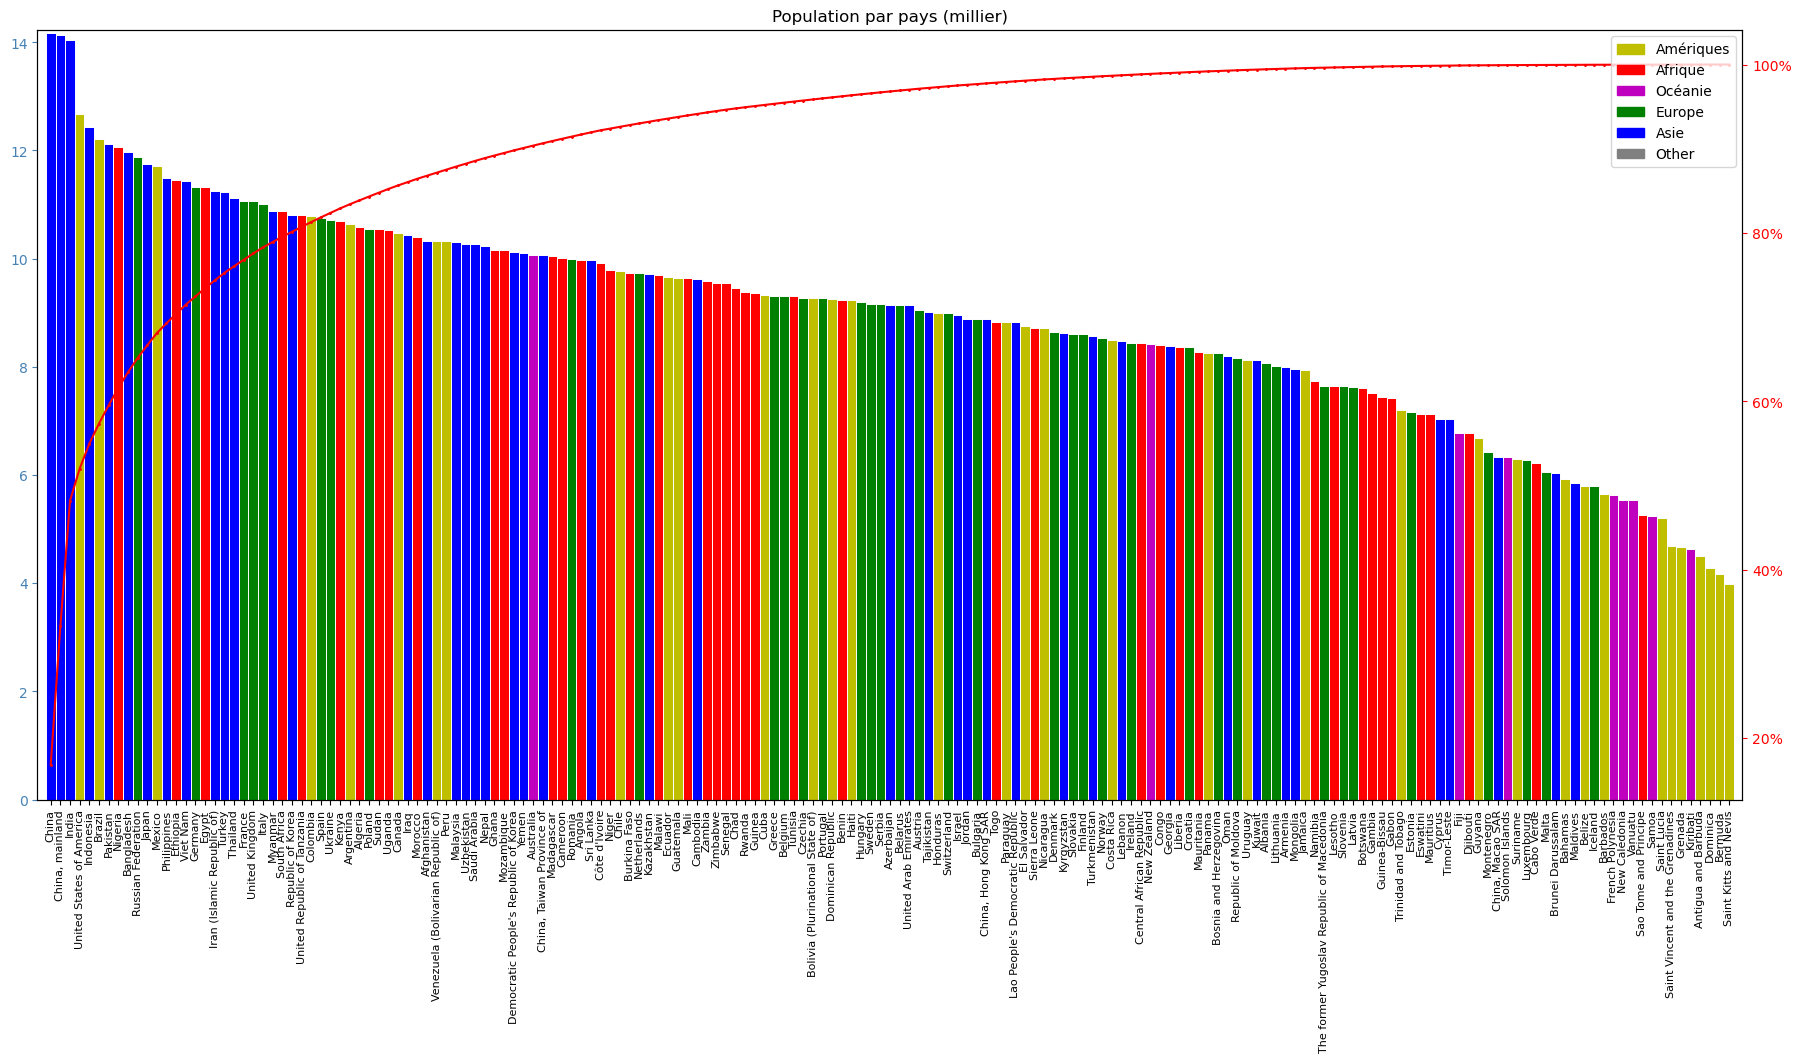

In [7]:

SQL = f"""
SELECT population.Pays, Valeur AS Population, "Groupe de pays"
FROM population
LEFT JOIN Groupe_de_pays ON population."Code Pays"=Groupe_de_pays."Code Pays"
WHERE "Groupe de pays" IN {list_groupes}
"""

title = "Population par pays (millier)"

pareto(SQL, 'Pays', 'Population', title, "Groupe de pays", dictColor)


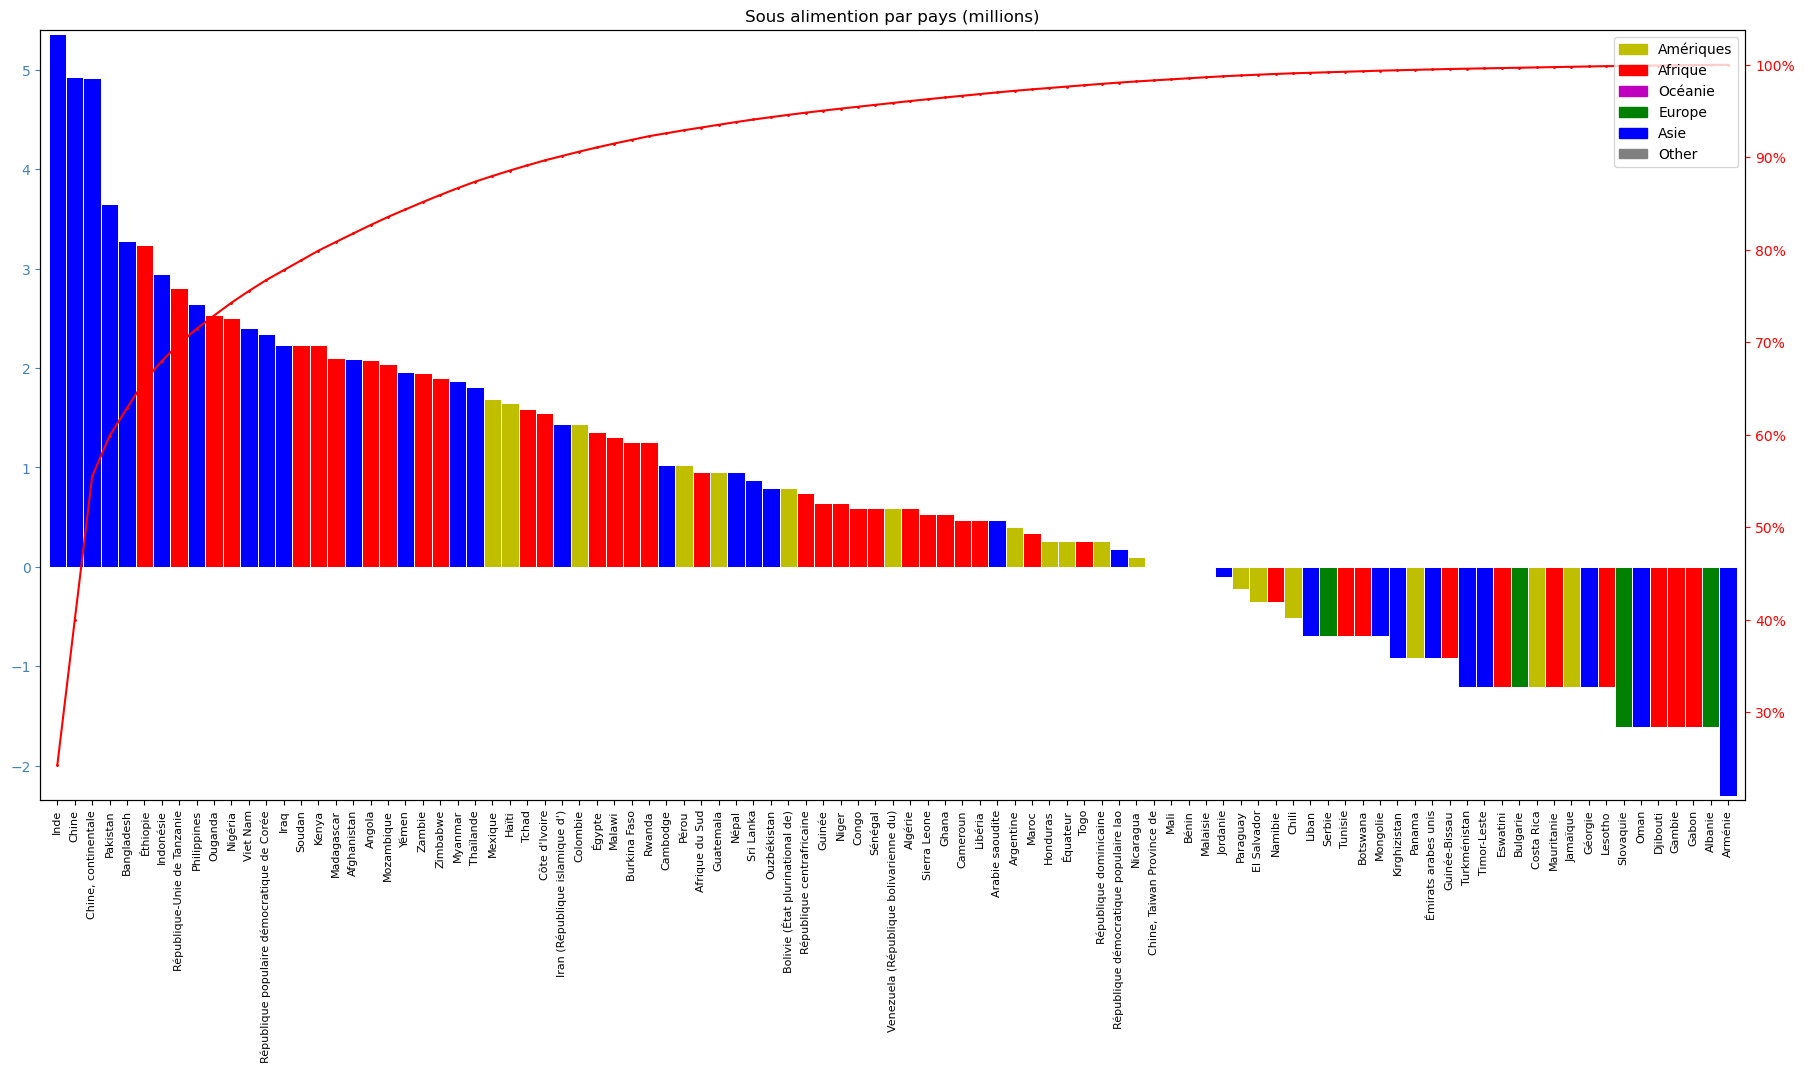

In [8]:

SQL = f"""
SELECT sous_alimentation.Pays, Valeur AS 'Sous alimentation', "Groupe de pays"
FROM sous_alimentation
LEFT JOIN Groupe_de_pays ON sous_alimentation."Code Pays"=Groupe_de_pays."Code Pays"
WHERE Valeur > 0 AND "Groupe de pays" IN {list_groupes}
"""

title = "Sous alimention par pays (millions)"

pareto(SQL, 'Pays', 'Sous alimentation', title, "Groupe de pays", dictColor)


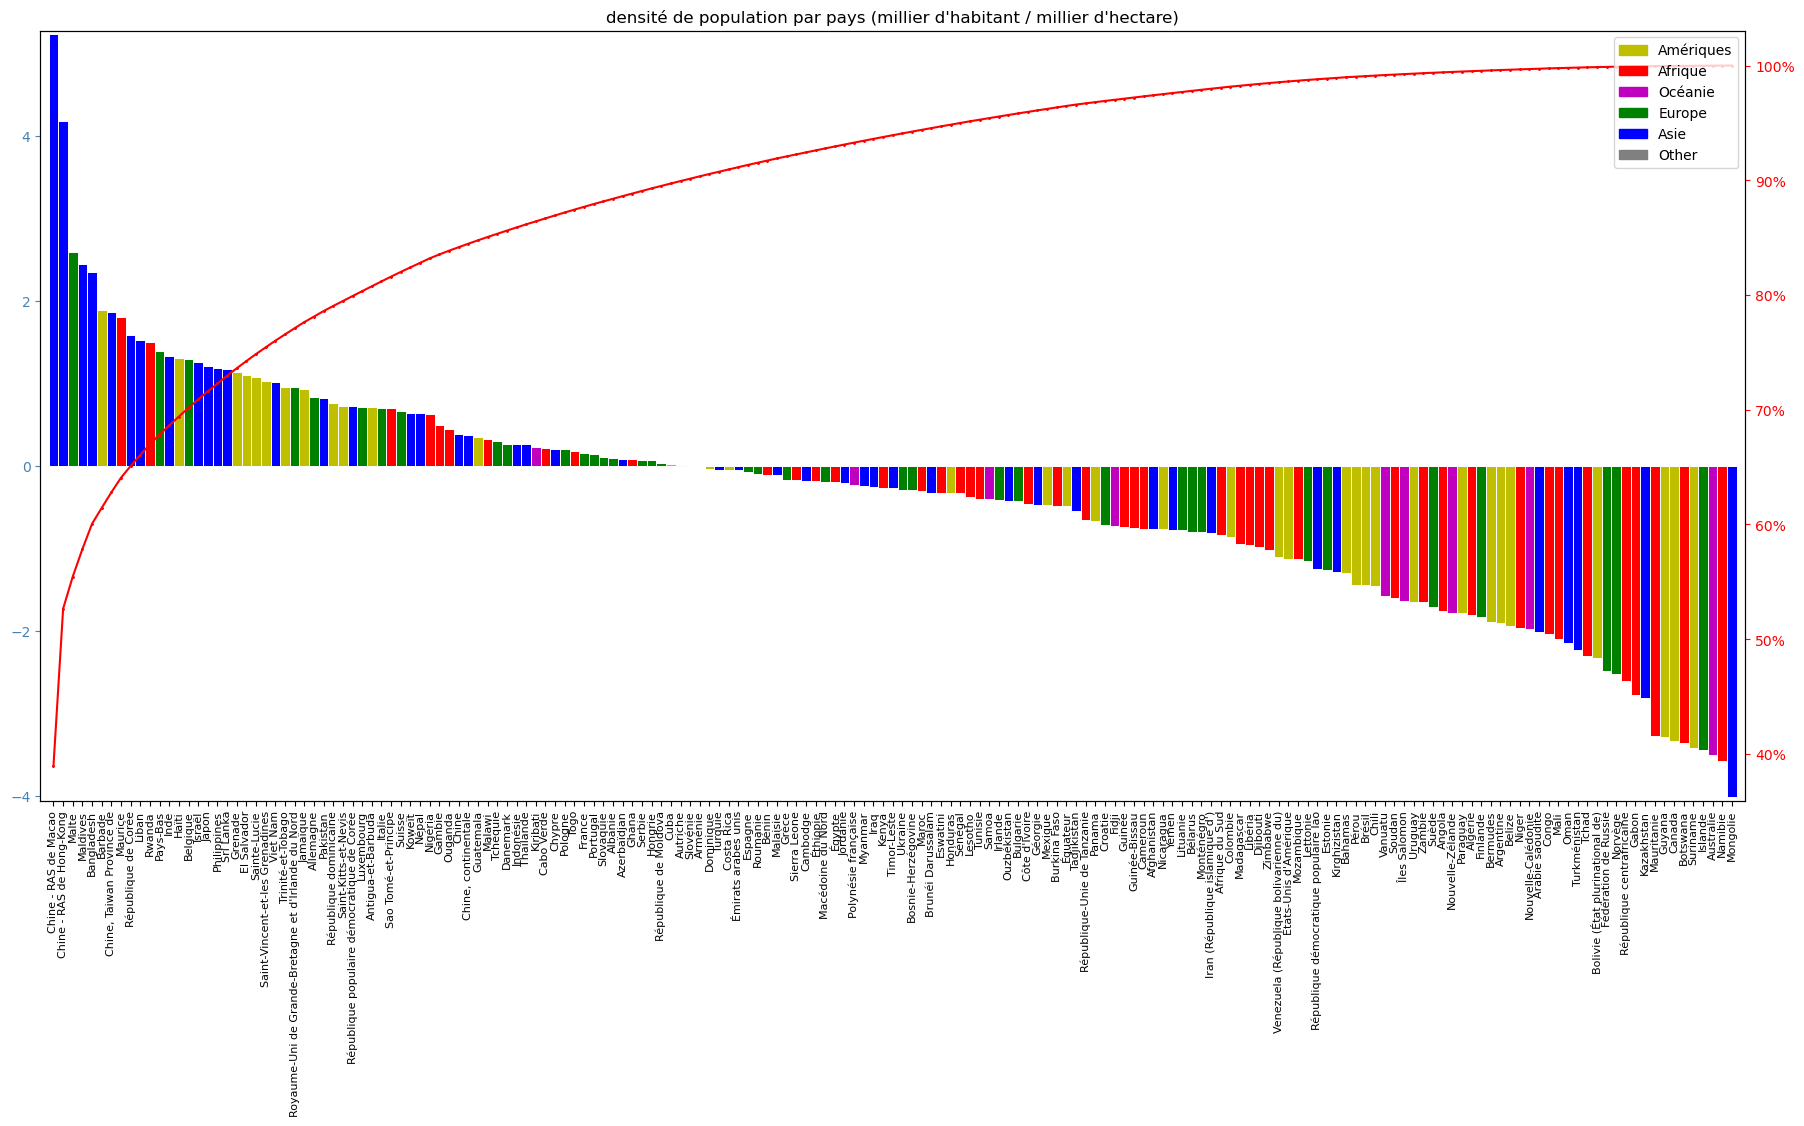

In [9]:

SQL = f"""
SELECT superficie.Pays, population.Valeur / superficie.Valeur AS 'Densité', "Groupe de pays"
FROM superficie
JOIN population ON superficie."Code Pays"=population."Code Pays"
LEFT JOIN Groupe_de_pays ON superficie."Code Pays"=Groupe_de_pays."Code Pays"
WHERE "Groupe de pays" IN {list_groupes}
"""

title = "densité de population par pays (millier d'habitant / millier d'hectare)"

pareto(SQL, 'Pays', 'Densité', title, "Groupe de pays", dictColor)
